# Extract an arbitrary line from a 3D volume

Arbitrary lines are often defined as peicewise lines on time/z slices or basemap views that draw a path through features of interest or for example betweem well locations.

By extracting an arbitrary line we hope to end up with a uniformly sampled vertical section of data that traverses the path where the sampling interval is. of the order of the bin interval of the dataset



In [1]:
%load_ext autoreload
%autoreload 2

from os import path

## Load Small 3D Volume from Volve

In [2]:
volve_3d_path = path.join("..", "data", "volve10r12-full-twt-sub3d.sgy")
print("3D", volve_3d_path, path.exists(volve_3d_path))

3D ../data/volve10r12-full-twt-sub3d.sgy True


In [3]:
from segysak.segy import segy_loader, get_segy_texthead, segy_header_scan, segy_header_scrape, well_known_byte_locs

volve_3d = segy_loader(volve_3d_path, **well_known_byte_locs("petrel_3d"))

/Users/stevejpurves/dev/swung/segysak/segysak/_accessor.py:110: AccessorRegistrationWarning: registration of accessor <class 'segysak._accessor.SeisArbLine'> under name 'seis' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  @xr.register_dataset_accessor("seis")



Fast direction is CDP


In [4]:
volve_3d.coords["iline"].min().item()

10090

In [5]:
from types import SimpleNamespace
import numpy as np

def get_survey_extents(seismic_3d):
    return SimpleNamespace(
        iline=(seismic_3d.coords["iline"].min().item(), seismic_3d.coords["iline"].max().item()),
        xline=(seismic_3d.coords["xline"].min().item(), seismic_3d.coords["xline"].max().item())
    )

def sel(seismic_3d, name, iline, xline):
    return seismic_3d[name].sel(iline=iline, xline=xline)

def sel_point(seismic_3d, iline, xline):
    return SimpleNamespace(
        cdp_x=sel(seismic_3d, "cdp_x", iline, xline).values.item(),
        cdp_y=sel(seismic_3d, "cdp_y", iline, xline).values.item(),
        iline=iline, xline=xline)

def get_survey_bounding_box(seismic_3d):
    extents = get_survey_extents(seismic_3d)
    
    P0 = sel_point(seismic_3d, extents.iline[0], extents.xline[0])
    P1 = sel_point(seismic_3d, extents.iline[0], extents.xline[1])
    P2 = sel_point(seismic_3d, extents.iline[1], extents.xline[1])
    P3 = sel_point(seismic_3d, extents.iline[1], extents.xline[0])
    
    return np.array([P0, P1, P2, P3])

In [6]:
get_survey_extents(volve_3d)
sel(volve_3d, "cdp_x", iline=10091, xline=2150)
sel_point(volve_3d, iline=10091, xline=2150)

namespace(cdp_x=436403.54000000004, cdp_y=6477459.17, iline=10091, xline=2150)

In [7]:
bb = get_survey_bounding_box(volve_3d)

In [8]:
for b in zip(bb, np.roll(bb, -1)):
    print(b)

(namespace(cdp_x=436400.52, cdp_y=6477447.04, iline=10090, xline=2150), namespace(cdp_x=433962.67, cdp_y=6478054.94, iline=10090, xline=2351))
(namespace(cdp_x=433962.67, cdp_y=6478054.94, iline=10090, xline=2351), namespace(cdp_x=434144.13, cdp_y=6478782.66, iline=10150, xline=2351))
(namespace(cdp_x=434144.13, cdp_y=6478782.66, iline=10150, xline=2351), namespace(cdp_x=436581.98, cdp_y=6478174.76, iline=10150, xline=2150))
(namespace(cdp_x=436581.98, cdp_y=6478174.76, iline=10150, xline=2150), namespace(cdp_x=436400.52, cdp_y=6477447.04, iline=10090, xline=2150))


In [9]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plot_bounds(seismic_3d, ax=None):
    bb = get_survey_bounding_box(seismic_3d)
    
    if not ax:
        fig, ax = plt.subplots(1,1)
        
    ax.scatter([b.cdp_x for b in bb],[b.cdp_y for b in bb])
    for pa, pb in zip(bb, np.roll(bb, -1)):
        ax.plot([pa.cdp_x, pb.cdp_x], [pa.cdp_y, pb.cdp_y], 'k:')
        
    ax.set_xlabel('cdp x')
    ax.set_ylabel('cdp y')
    return ax

In [21]:
arb_line_in = (np.array([434300, 434600, 435500, 436300]), np.array([6.4786e6, 6.4780e6, 6.4779e6, 6.4781e6]))
arb_line_out = (np.array([434000, 434600, 435500, 436500]), np.array([6.4786e6, 6.4776e6, 6.4786e6, 6.4775e6]))

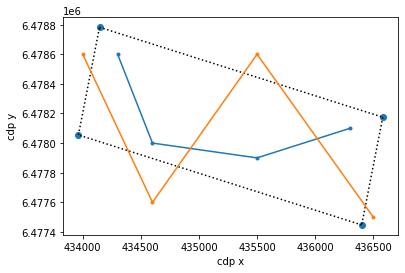

In [22]:
ax = plot_bounds(volve_3d)
ax.plot(arb_line_in[0], arb_line_in[1], '.-')
ax.plot(arb_line_out[0], arb_line_out[1], '.-')

In [23]:
volve_3d.seis.line_interp(arb_line_in[0], arb_line_in[1])

(array([10138.83864289, 10098.07144973, 10107.72966132, 10138.73932208]),
 array([2335.36543294, 2300.46467376, 2228.66861198, 2170.44106726]))

In [25]:
norm_line = (arb_line_in[0]-arb_line_in[0][0], arb_line_in[1]-arb_line_in[1][0])
norm_path = [(x**2 + y**2)**0.5 for x,y in zip(*norm_line)]

In [39]:
from scipy.interpolate import interp1d

bin_spacing = 8
num_pts = int(norm_path[-1] / bin_spacing)

new_path, spacing = np.linspace(0, norm_path[-1], num_pts, retstep=True)

cdp_x_interpolator = interp1d(norm_path, arb_line_in[0])(new_path)
cdp_y_interpolator = interp1d(norm_path, arb_line_in[1])(new_path)

print(spacing)

8.052940675034494
